Plan: compare MSE of (rescaled) features of small (~200x200) test image(s) across different upsampling methods to Hy-Dv2. These methods will be: bicubic upsampling of original Dv2, bicubic upsampling of VE, blurring of nearest upsampling of VE. 

In [1]:
# Imports
import torch
torch.cuda.empty_cache()
torch.manual_seed(0)
from torch.nn.functional import interpolate


from hr_dv2 import HighResDV2, torch_pca
import hr_dv2.transform as tr
from hr_dv2.utils import *
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt



from featup.util import norm, unnorm
use_norm = True

/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_img(path: str) -> tuple[torch.Tensor, np.ndarray]:
    temp_img = Image.open(path)
    h, w = temp_img.height, temp_img.width
    transform = tr.closest_crop(h, w, patch_size=14)
    tensor, img = tr.load_image(path, transform)
    H, W = img.height, img.width
    return tensor, np.array(img)

In [3]:
strides = [8, 4, 1, 4]
resizes = ['nearest-exact', 'nearest-exact', 'featup', 'nearest-exact']

In [4]:
out = []
img_paths = ["kitchen", "train"]
for img_path in img_paths:
    
    for i, method in enumerate(resizes):
        torch.cuda.empty_cache()
        fname = f"fig_data/{img_path}.jpg"
        tensor, img_arr = load_img(fname)
        H, W, C = img_arr.shape
        tensor = tensor.cuda()
        print(f"{img_path}: {method}")
        if i == 2:
            net = torch.hub.load("mhamilton723/FeatUp", 'dinov2', use_norm=use_norm)
            img_tensor = tensor.unsqueeze(0)
        else:
            net = HighResDV2("dino_vits8", strides[i], dtype=torch.float16)
            net.interpolation_mode = resizes[i]
            if i == 3:
                fwd_shift, inv_shift = tr.get_shift_transforms([1, 2,], 'Moore')
                fwd_flip, inv_flip = tr.get_flip_transforms()
                fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)
                net.set_transforms(fwd, inv)
            img_tensor = tensor
        net.cuda()
        net.eval()
        feats_attn_tensor = net.forward(img_tensor)

        if i == 2:
            feats_attn_tensor = interpolate(feats_attn_tensor, (H, W))
        print(feats_attn_tensor.shape)
        pcaed = torch_pca(feats_attn_tensor.squeeze(0), 3, max_samples=80000)
        pcaed = tr.to_numpy(pcaed)
        rescaled = rescale_pca(pcaed)
        out.append(rescaled)

/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


kitchen: nearest-exact


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


torch.Size([1, 384, 364, 490])
kitchen: nearest-exact


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


torch.Size([1, 384, 364, 490])
kitchen: featup


Using cache found in /home/ronan/.cache/torch/hub/mhamilton723_FeatUp_main
/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/featup-0.1.2-py3.10-linux-x86_64.egg/featup/featurizers/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/featup-0.1.2-py3.10-linux-x86_64.egg/featup/featurizers/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/featup-0.1.2-py3.10-linux-x86_64.egg/featup/featurizers/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warn

torch.Size([1, 384, 364, 490])
kitchen: nearest-exact
torch.Size([1, 384, 364, 490])
train: nearest-exact


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


torch.Size([1, 384, 322, 490])
train: nearest-exact


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


torch.Size([1, 384, 322, 490])
train: featup


Using cache found in /home/ronan/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


torch.Size([1, 384, 322, 490])
train: nearest-exact


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


torch.Size([1, 384, 322, 490])


Upsampling based comparisons:

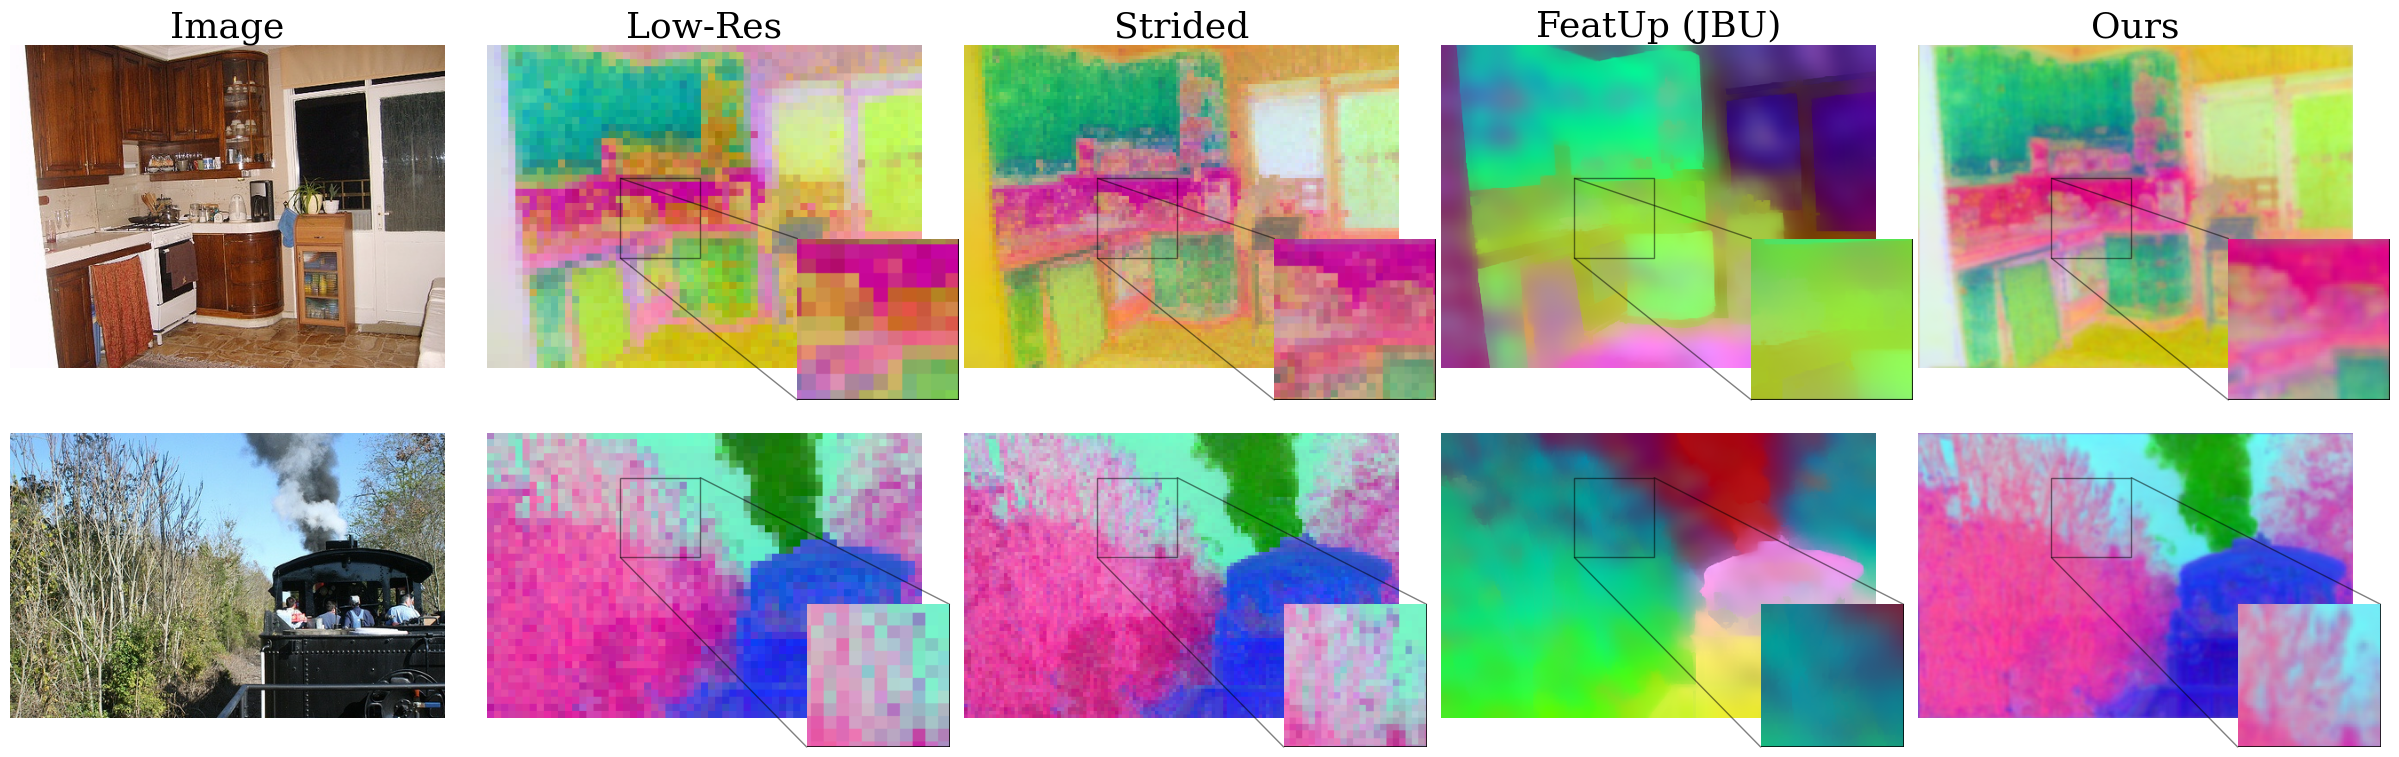

In [6]:
fig, axs = plt.subplots(len(img_paths), len(resizes) + 1)
fig.set_size_inches(24, 8)
plt.rcParams["font.family"] = "serif"
titles = ["Low-Res", "Strided", "FeatUp (JBU)", "Ours"]
#plt.suptitle("3 component PCAs", fontsize=30)

i = 0
for row, path in enumerate(img_paths):
    fname = f"fig_data/{path}.jpg"
    _, img_arr = load_img(fname)
    H, W, C = img_arr.shape
    axs[row, 0].imshow(img_arr)
    axs[row, 0].set_axis_off()
    if row == 0:
        axs[row, 0].set_title("Image", fontsize=26)

    for column in range(0, len(resizes)):
        ax = axs[row, column + 1]
        data = out[i]

        img = data.reshape((H, W, 3))
        ax.imshow(img)
        if row == 0:
            ax.set_title(titles[column], fontsize=26)
        ax.set_axis_off()

        if row == 0:
            x0, y0, w, h = [150, 150, 90, 90]
        else:
            x0, y0, w, h = [150, 50, 90, 90]
        inset_data = np.zeros_like(img)
        inset_data[y0:y0+h, x0:x0+w, :] = img[y0:y0+h, x0:x0+w, :]
        extent = (0, H, W, 0)
        # 418 / 518, 0 / 518, 150 / 518, 150 / 518
        axin = ax.inset_axes(
            [0.65, -0.1, 0.5, 0.5], xlim=(x0, x0+w), ylim=(y0, y0+h))
        axin.set_axis_off()
        axin.imshow(inset_data)
        ax.indicate_inset_zoom(axin, edgecolor="black")
        axin.set_ylim((y0 + h, y0))

        i += 1


plt.tight_layout()
plt.savefig('out/resolution_comparison.png')